In [2]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

# VEST AL 2018
---

## VEST Documentation

### Election Results

#### Sources
Election results from the Alabama Secretary of State Elections Division (https://www.sos.alabama.gov/alabama-votes/voter/election-data). 

Incorrect or incomplete data was replaced using the county canvass reports for the following counties: Dallas, Chilton, Covington, Escambia, Lauderdale, Monroe, Pickens, Russell.


#### Processing
Absentee and provisional ballots were reported countywide in all counties. These were distributed by candidate to precincts based on their share of the precinct-level reported vote.


### Shapefiles

#### Sources
Precinct shapefiles initially from the U.S. Census Bureau's 2020 Redistricting Data Program final release, except the following counties use shapefiles sourced from the respective county governments instead: Baldwin, Blount, Calhoun, Cullman, DeKalb, Franklin, Jefferson, Lee, Limestone, Madison, Marengo, Marshall, Mobile, Montgomery, Morgan, St. Clair, Shelby, Talladega, Tuscaloosa.

### Processing
Precinct boundaries were adjusted as appropriate to align with county maps, municipal boundaries, or commission districts. Precinct boundaries throughout the state were further reviewed with the voter registration file in effect for the November 2018 general election. Voting districts in nearly all counties were edited accordingly to align with reporting units in the 2018 election results. In many counties the resulting boundaries bear little resemblance to the 2020 Census VTDs. As these boundary revisions were so extensive only splits and merges are specified below by precinct.

Many precincts have outdated names in the Census VTDs. The Census VTDs also have at least some precinct names in wrong locations for the following counties: Clarke, Clay, Cleburne, Conecuh, Dallas, Escambia, Geneva, Greene, Jefferson, Lauderdale, Limestone, Marion, Marshall, Monroe, Perry, Randolph, Russell, Tallapoosa, Walker, Washington, Wilcox. Moreover, many precinct numbers and consequently the VTD GeoIDs are also incorrect throughout much of the state in the Census shapefiles. All precinct names and numbers have been edited to match the 2018 voter file.

The following splits and merges were made to align voting district boundaries with reporting units in the 2018 election results.

- Barbour: Split Eufaula between Bevill/CC/Fellowship/McCoo/Sanford/WB
- Calhoun: Add precinct splits to Beats 1, 4, 5, 9, 12, 13, 15, 19, 22
- Cherokee: Split Friendship/Mt Calvary, McCord's/Rock Run, Mt Weisner/VFD #2
- Choctaw: Split Cromwell/Halsell/Intersection
- Clarke: Split Antioch/Grove Hill/Helwestern, Choctaw Bluff/Gainstown, Grove Hill NG/Whatley, Jackson/Skipper, Springfield/Thomasville; Merge Fulton FS/CH
- Covington: Split Heath/Straughn, Pleasant Home/Wing
- Cullman: Split Cullman City Hall/Civic Ctr/Conf Room/Courthouse
- Dallas: Merge Marion Jct/New Friendship
- Etowah: Merge Fords Valley/Hokes Bluff, Tabernacle/Walnut Park
- Fayette: Split Browns-Glen Allen/Whites Chapel, Cole-Killingsworth/Paul Hubbert, Elm Grove/Studdard's, Fayette CC/Covin/YC, Lee-Belk/Palestine
- Geneva: Split Bellwood/Chancellor, Flat Creek/Hacoda, Geneva CC/CH/CO/FC/NG, Hughes VH/Malvern, Lowery/Revels, Piney Grove/Samson/Samson Masonic, Slocomb/Tate
- Jackson: Split Holly Springs/Pleasant Groves
- Jefferson: Split 3020/3025 Pleasant Hill/McAdory; Merge 2350/5270 as Oxmoor Valley
- Marion: Split Kimbrough N/S; Merge Hamilton N/S as ET Sims
- Monroe: Split Chrysler/Mineola, Coleman/Excel, Franklin/Wainwright, Peterman/Philadelphia
- Randolph: Split Bethel/Moores/Woodland, Cavers/Swagg, Corinth/Morrison, Midway/New Hope/Wedowee, Omaha/Tin Shop/Wehadkee, Rock Mills/Wilson
- Russell: Split Courthouse/Golden Acres
- Tallapoosa: Split Cooper/Duncan/Moncrief; Merge New Paces 901/902 to match county shapefile
- Wilcox: Split National Guard Camden, Pine Apple Comm Ctr, Pine Apple AWIN, St Paul Church
- Winston: Split Addison/Upshaw, Delmar/Natural Bridge, Haleyville/Neighborhood/Pebble/Waldrop, Lynn/Old Union, Nesmith/Helicon


# Election Result Processing

## Get VEST file and FIPS dictionary ready

### Load in VEST file

In [3]:
vest_al_18 = gp.read_file("./raw-from-source/VEST/al_2018/al_2018.shp")

In [4]:
vest_al_18.crs

{'init': 'epsg:4269'}

<AxesSubplot:>

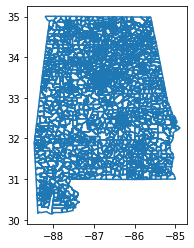

In [5]:
vest_al_18.boundary.plot()

In [6]:
vest_al_18.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST18', 'GEOID18', 'NAME18', 'G18GOVRIVE',
       'G18GOVDMAD', 'G18GOVOWRI', 'G18LTGRAIN', 'G18LTGDBOY', 'G18LTGOWRI',
       'G18ATGRMAR', 'G18ATGDSIE', 'G18ATGOWRI', 'G18TRERMCM', 'G18TREOWRI',
       'G18AGRRPAT', 'G18AGROWRI', 'G18SOSRMER', 'G18SOSDMIL', 'G18SOSOWRI',
       'G18AUDRZEI', 'G18AUDDJOS', 'G18AUDOWRI', 'G18SSCRPAR', 'G18SSCDVAN',
       'G18SSCOWRI', 'G18SSCRSTE', 'G18SSCOWR2', 'G18SSCRBRY', 'G18SSCOWR3',
       'G18SSCRSEL', 'G18SSCOWR4', 'G18SSCRMIT', 'G18SSCDSMA', 'G18SSCOWR5',
       'G18SACREDW', 'G18SACOWRI', 'G18SACRHAN', 'G18SACOWR2', 'G18SACRMOO',
       'G18SACOWR3', 'G18SCCRMIN', 'G18SCCOWRI', 'G18SCCRMCC', 'G18SCCOWR2',
       'G18SCCRCOL', 'G18SCCOWR3', 'G18PSCRODE', 'G18PSCDMCC', 'G18PSCOWRI',
       'G18PSCRBEE', 'G18PSCDPOW', 'G18PSCOWR2', 'geometry'],
      dtype='object')

In [7]:
vest_al_18.head(5)

,STATEFP20,COUNTYFP20,VTDST18,GEOID18,NAME18,G18GOVRIVE,G18GOVDMAD,G18GOVOWRI,G18LTGRAIN,G18LTGDBOY,...,G18SCCOWR2,G18SCCRCOL,G18SCCOWR3,G18PSCRODE,G18PSCDMCC,G18PSCOWRI,G18PSCRBEE,G18PSCDPOW,G18PSCOWR2,geometry
0,01,013,000100,01013000100,Monterey School House,25,29,0,22,31,...,2,23,2,22,30,0,22,30,0,"POLYGON ((-86.90894 31.96167, -86.90632 31.961..."
1,01,013,000181,01013000181,Bolling,73,37,0,71,35,...,4,70,4,69,35,0,69,35,0,"POLYGON ((-86.71867 31.73289, -86.71864 31.732..."
2,01,053,000080,01053000080,Rock Hill-Ridge VFD,167,62,4,164,66,...,2,169,2,163,65,0,161,65,0,"POLYGON ((-87.05166 31.11854, -87.04869 31.118..."
3,01,053,000120,01053000120,Damascus-Boykin School,145,101,0,130,110,...,1,129,1,129,107,0,128,105,0,"POLYGON ((-86.95858 31.16635, -86.95844 31.166..."
4,01,053,000100,01053000100,Bradley VFD,53,6,0,52,5,...,0,49,0,50,3,0,50,3,0,"POLYGON ((-86.82985 31.02083, -86.82983 31.020..."


### Create a FIPs dictionary

In [8]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Alabama"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
al_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Election Results

### Load, Pivot, Clean Election Results

There is a directory of excel files that need to be pivoted of election results. 

First, confirm that the file structure is the same for all of the files:

In [9]:
files = os.listdir('./raw-from-source/SOS/2018-Official-General-Precinct-Results/')

In [11]:
temp = pd.read_excel('./raw-from-source/SOS/2018-Official-General-Precinct-Results/2018-General-Autauga.xls')
columns = temp.columns
print(columns)

flag = True
for file in files: 
    temp = pd.read_excel('./raw-from-source/SOS/2018-Official-General-Precinct-Results/' + file)
    if columns.to_list()[:3] != temp.columns.to_list()[:3]:
        print(columns)
        print(temp.columns)
        flag = False
if flag:
    print('All files have the same first 3 columns: ', columns.to_list()[:3])

Index(['Contest Title', 'Party', 'Candidate', '10 JONES COMMUNITY CTR',
       '100 TRINITY METHODIST', '110 CENTRAL AL ELECTRIC',
       '140 AUTAUGAVILLE VFD', '150 PRATTMONT BAPTIST CH',
       '160 DOSTER COMMUNITY CTR', '170 CAMELLIA BAPTIST CH',
       '180 OLD KINGSTON VFD', '20 HERITAGE BAPTIST', '220 UPPER KINGSTON',
       '230 COUNTY LINE BAPTIST', '30 BILLINGSLEY COMM_ CTR_',
       '40  E_MEMORIAL CHRISTIAN', '50 WHITE CITY VFD',
       '60 MARBURY MIDDLE SCH', '70 BOONE'S CHAPEL', '80 INDEPENDENCE VFD',
       '90 BOOTH VFD', 'ABSENTEE', 'PROVISIONAL'],
      dtype='object')
All files have the same first 3 columns:  ['Contest Title', 'Party', 'Candidate']


Next, go through and pivot each file, clean them, and concatenate. 

In [62]:
def pivot_clean_county_file(df, county_name): 
    """Given a dataframe, pivot the table, order and rename columns, and return the cleaned table that can be concatenated. """
    
    df_pivot = pd.pivot_table(df,values=[x for x in df.columns.to_list() if x not in ('Contest Title','Party','Candidate')],
                              columns=['Contest Title',"Candidate"],aggfunc=sum)
    df_pivot['county'] = county_name
    df_pivot.reset_index(inplace = True)
    df_pivot.columns = [(x.strip(), y.strip()) for x,y in df_pivot.columns.values]
        
    if county_name in ('Covington','Lauderdale','Escambia','Monroe','Pickens'):
        cols_to_add = [('CHIEF JUSTICE OF THE SUPREME COURT', 'Write-In'), ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 3', 'Write-In'), ('ATTORNEY GENERAL', 'Write-In'), ('COURT OF CIVIL APPEALS JUDGE, PLACE 2', 'Write-In'), ('PUBLIC SERVICE COMMISSION, PLACE 2', 'Write-In'), ('SECRETARY OF STATE', 'Write-In'), ('STATE AUDITOR', 'Write-In'), ('COMMISSIONER OF AGRICULTURE AND INDUSTRIES', 'Write-In'), ('LIEUTENANT GOVERNOR', 'Write-In'), ('COURT OF CIVIL APPEALS JUDGE, PLACE 1', 'Write-In'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 4', 'Write-In'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 1', 'Write-In'), ('COURT OF CIVIL APPEALS JUDGE, PLACE 3', 'Write-In'), ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 1', 'Write-In'), ('GOVERNOR', 'Write-In'), ('STATE TREASURER', 'Write-In'), ('PUBLIC SERVICE COMMISSION, PLACE 1', 'Write-In'), ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 2', 'Write-In'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 3', 'Write-In'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 2', 'Write-In')]
        for x,y in cols_to_add:
            df_pivot[x,y] = 0
    
    if county_name == 'Marion':
        ajsc1 = [('ASSOCIATE JUSTICE OF THE SUPREME COURT. PLACE NO. 1', 'Sarah Hicks Stewart'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT. PLACE NO. 1', 'Write-In')]
    else:
        ajsc1 = [('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 1', 'Sarah Hicks Stewart'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 1', 'Write-In')]
    
    clean_df = df_pivot[[('index',''),('county',''),
                        ('GOVERNOR', 'Kay Ivey'), ('GOVERNOR', 'Walt Maddox'), ('GOVERNOR', 'Write-In'),
                        ('LIEUTENANT GOVERNOR', 'Will Ainsworth'), ('LIEUTENANT GOVERNOR', 'Will Boyd'), ('LIEUTENANT GOVERNOR', 'Write-In'),
                        ('ATTORNEY GENERAL', 'Steve Marshall'), ('ATTORNEY GENERAL', 'Joseph Siegelman'), ('ATTORNEY GENERAL', 'Write-In'),
                        ('STATE TREASURER', 'John McMillan'), ('STATE TREASURER', 'Write-In'),
                        ('COMMISSIONER OF AGRICULTURE AND INDUSTRIES', 'Rick Pate'), ('COMMISSIONER OF AGRICULTURE AND INDUSTRIES', 'Write-In'),
                        ('SECRETARY OF STATE', 'John H. Merrill'), ('SECRETARY OF STATE', 'Heather Milam'), ('SECRETARY OF STATE', 'Write-In'),
                        ('STATE AUDITOR', 'Jim Zeigler'), ('STATE AUDITOR', 'Miranda Karrine Joseph'), ('STATE AUDITOR', 'Write-In'), 
                        ('CHIEF JUSTICE OF THE SUPREME COURT', 'Tom Parker'), ('CHIEF JUSTICE OF THE SUPREME COURT', 'Bob Vance, Jr.'), ('CHIEF JUSTICE OF THE SUPREME COURT', 'Write-In')]
                        + ajsc1 +
                        [('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 2', 'Tommy Bryan'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 2', 'Write-In'),
                        ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 3', 'Will Sellers'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 3', 'Write-In'),
                        ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 4', 'Jay Mitchell'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 4', 'Donna Wesson Smalley'), ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 4', 'Write-In'),
                        ('COURT OF CIVIL APPEALS JUDGE, PLACE 1', 'Christy Olinger Edwards'), ('COURT OF CIVIL APPEALS JUDGE, PLACE 1', 'Write-In'),
                        ('COURT OF CIVIL APPEALS JUDGE, PLACE 2', 'Chad Hanson'), ('COURT OF CIVIL APPEALS JUDGE, PLACE 2', 'Write-In'), 
                        ('COURT OF CIVIL APPEALS JUDGE, PLACE 3', 'Terry A. Moore'), ('COURT OF CIVIL APPEALS JUDGE, PLACE 3', 'Write-In'), 
                        ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 1', 'Richard Minor'), ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 1', 'Write-In'), 
                        ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 2', 'Chris McCool'), ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 2', 'Write-In'), 
                        ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 3', 'Bill Cole'), ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 3', 'Write-In'),
                        ('PUBLIC SERVICE COMMISSION, PLACE 1', 'Jeremy H. Oden'), ('PUBLIC SERVICE COMMISSION, PLACE 1', 'Cara Y. McClure'), ('PUBLIC SERVICE COMMISSION, PLACE 1', 'Write-In'), 
                        ('PUBLIC SERVICE COMMISSION, PLACE 2', 'Chris "Chip" Beeker Jr.'), ('PUBLIC SERVICE COMMISSION, PLACE 2', 'Kari Powell'), ('PUBLIC SERVICE COMMISSION, PLACE 2', 'Write-In')]]
    clean_df.columns = ['precinct','county','G18GOVRIVE',
                        'G18GOVDMAD', 'G18GOVOWRI', 'G18LTGRAIN', 'G18LTGDBOY', 'G18LTGOWRI',
                        'G18ATGRMAR', 'G18ATGDSIE', 'G18ATGOWRI', 'G18TRERMCM', 'G18TREOWRI',
                        'G18AGRRPAT', 'G18AGROWRI', 'G18SOSRMER', 'G18SOSDMIL', 'G18SOSOWRI',
                        'G18AUDRZEI', 'G18AUDDJOS', 'G18AUDOWRI', 'G18SSCRPAR', 'G18SSCDVAN',
                        'G18SSCOWRI', 'G18SSCRSTE', 'G18SSCOWR2', 'G18SSCRBRY', 'G18SSCOWR3',
                        'G18SSCRSEL', 'G18SSCOWR4', 'G18SSCRMIT', 'G18SSCDSMA', 'G18SSCOWR5',
                        'G18SACREDW', 'G18SACOWRI', 'G18SACRHAN', 'G18SACOWR2', 'G18SACRMOO',
                        'G18SACOWR3', 'G18SCCRMIN', 'G18SCCOWRI', 'G18SCCRMCC', 'G18SCCOWR2',
                        'G18SCCRCOL', 'G18SCCOWR3', 'G18PSCRODE', 'G18PSCDMCC', 'G18PSCOWRI',
                        'G18PSCRBEE', 'G18PSCDPOW', 'G18PSCOWR2']
    
    return clean_df



In [67]:
flag = 0
for file in files: 
    temp = pd.read_excel('./raw-from-source/SOS/2018-Official-General-Precinct-Results/' + file)
#     print(file.split('-')[2][:-4])
    clean_df = pivot_clean_county_file(temp, file.split('-')[2][:-4])
    if flag == 0:
        results_2018 = clean_df
        flag = 1
    else:
        results_2018 = pd.concat([results_2018, clean_df])

Add county fips to election results file

In [68]:
# Change column names to match the county fips dict
results_2018.loc[results_2018['county'] == 'StClair', 'county'] = 'St Clair'
results_2018.loc[results_2018['county'] == 'DeKalb', 'county'] = 'De Kalb'

#Map to the correct FIP
results_2018["county_fips"]=results_2018["county"].map(al_fips_dict).fillna(results_2018["county"])

#Print out the FIPS to make sure they all are in the correct format
results_2018["county_fips"].unique()

array(['081', '083', '005', '003', '017', '111', '113', '039', '067',
       '019', '077', '029', '115', '097', '041', '051', '055', '117',
       '057', '123', '103', '035', '075', '061', '023', '027', '089',
       '133', '129', '047', '025', '011', '109', '033', '021', '053',
       '037', '059', '119', '105', '071', '031', '087', '121', '007',
       '015', '009', '091', '013', '131', '095', '125', '099', '065',
       '049', '127', '045', '043', '085', '101', '073', '107', '079',
       '063', '093', '001', '069'], dtype=object)

In [69]:
results_2018.shape

(2240, 52)

In [70]:
vest_al_18.shape

(1992, 55)

## Compare Election Results Totals

### Compare Total Votes

In [71]:
races = [x for x in vest_al_18.columns if 'G18' in x]
races

['G18GOVRIVE',
 'G18GOVDMAD',
 'G18GOVOWRI',
 'G18LTGRAIN',
 'G18LTGDBOY',
 'G18LTGOWRI',
 'G18ATGRMAR',
 'G18ATGDSIE',
 'G18ATGOWRI',
 'G18TRERMCM',
 'G18TREOWRI',
 'G18AGRRPAT',
 'G18AGROWRI',
 'G18SOSRMER',
 'G18SOSDMIL',
 'G18SOSOWRI',
 'G18AUDRZEI',
 'G18AUDDJOS',
 'G18AUDOWRI',
 'G18SSCRPAR',
 'G18SSCDVAN',
 'G18SSCOWRI',
 'G18SSCRSTE',
 'G18SSCOWR2',
 'G18SSCRBRY',
 'G18SSCOWR3',
 'G18SSCRSEL',
 'G18SSCOWR4',
 'G18SSCRMIT',
 'G18SSCDSMA',
 'G18SSCOWR5',
 'G18SACREDW',
 'G18SACOWRI',
 'G18SACRHAN',
 'G18SACOWR2',
 'G18SACRMOO',
 'G18SACOWR3',
 'G18SCCRMIN',
 'G18SCCOWRI',
 'G18SCCRMCC',
 'G18SCCOWR2',
 'G18SCCRCOL',
 'G18SCCOWR3',
 'G18PSCRODE',
 'G18PSCDMCC',
 'G18PSCOWRI',
 'G18PSCRBEE',
 'G18PSCDPOW',
 'G18PSCOWR2']

In [72]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_al_18[i])
    sum_var_2 += np.sum(results_2018[i])
print(sum_var_1)
print(sum_var_2)

27534810
27496872.0


### Compare County Totals

The `compare()` method shows rows where the values are different, by default. So displaying nothing here is good, all county race totals are equal. 

In [73]:
vest_al_18.groupby('COUNTYFP20')['G18GOVRIVE'].sum().compare(results_2018.groupby('county_fips')['G18GOVRIVE'].sum())

,self,other
021,11291.0,10487.0
047,4917.0,4542.0
113,7168.0,7166.0


So there are 3 problem counties. 021: Chilton, 047: Dallas, 113: Russell. Confirmed that these RDH results match the SOS Precinct-Level file. VEST documentation says: 
> Incorrect or incomplete data was replaced using the county canvass reports for the following counties: Dallas, Chilton, Covington, Escambia, Lauderdale, Monroe, Pickens, Russell.

Not sure where these files are coming from, but VEST's results match Ballotpedia, so SOS Precinct-Level results file is wrong? 

### Compare Race Totals

In [75]:
for race in races:
    diff_val = sum(vest_al_18[race])-sum(results_2018[race])
    if diff_val != 0:
        print(race+": "+str(diff_val), "\tVEST sum: ", sum(vest_al_18[race]), "\tRDH sum: ", sum(results_2018[race]))
    else:
        print(race+": EQUAL")

G18GOVRIVE: 1181.0 	VEST sum:  1022457 	RDH sum:  1021276.0
G18GOVDMAD: 484.0 	VEST sum:  694495 	RDH sum:  694011.0
G18GOVOWRI: 107.0 	VEST sum:  2637 	RDH sum:  2530.0
G18LTGRAIN: 1163.0 	VEST sum:  1044941 	RDH sum:  1043778.0
G18LTGDBOY: 480.0 	VEST sum:  660013 	RDH sum:  659533.0
G18LTGOWRI: 43.0 	VEST sum:  1023 	RDH sum:  980.0
G18ATGRMAR: 1140.0 	VEST sum:  1004438 	RDH sum:  1003298.0
G18ATGDSIE: 513.0 	VEST sum:  702858 	RDH sum:  702345.0
G18ATGOWRI: 44.0 	VEST sum:  1141 	RDH sum:  1097.0
G18TRERMCM: 1195.0 	VEST sum:  1085054 	RDH sum:  1083859.0
G18TREOWRI: 831.0 	VEST sum:  31968 	RDH sum:  31137.0
G18AGRRPAT: 1197.0 	VEST sum:  1081431 	RDH sum:  1080234.0
G18AGROWRI: 821.0 	VEST sum:  31312 	RDH sum:  30491.0
G18SOSRMER: 1159.0 	VEST sum:  1032425 	RDH sum:  1031266.0
G18SOSDMIL: 467.0 	VEST sum:  658537 	RDH sum:  658070.0
G18SOSOWRI: 39.0 	VEST sum:  1064 	RDH sum:  1025.0
G18AUDRZEI: 1145.0 	VEST sum:  1018466 	RDH sum:  1017321.0
G18AUDDJOS: 476.0 	VEST sum:  6656

# Precinct Shapefile

## Load in the shapefiles

### 2020 TIGER/Line

> Precinct shapefiles initially from the U.S. Census Bureau's 2020 Redistricting Data Program final release, except the following counties use shapefiles sourced from the respective county governments instead: Baldwin, Blount, Calhoun, Cullman, DeKalb, Franklin, Jefferson, Lee, Limestone, Madison, Marengo, Marshall, Mobile, Morgan, St. Clair, Shelby, Talladega, Tuscaloosa.

Link to the 2020 TIGER/Line files for AL, where we can download the VTD file, assuming the file did not change: 
https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/01_ALABAMA/01/

In [78]:
tiger_vtd = gp.read_file('./raw-from-source/Census/tl_2020_01_vtd20/tl_2020_01_vtd20.shp')

In [79]:
tiger_vtd.head(1)

,STATEFP20,COUNTYFP20,VTDST20,GEOID20,VTDI20,NAME20,NAMELSAD20,LSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,01,013,000010,01013000010,A,MONTEREY SCHOOL HOUSE,MONTEREY SCHOOL HOUSE,00,G5240,N,52684413,65831,+31.9295188,-086.8948172,"POLYGON ((-86.90894 31.96167, -86.90632 31.961..."


In [80]:
tiger_vtd.shape

(1837, 15)

<AxesSubplot:>

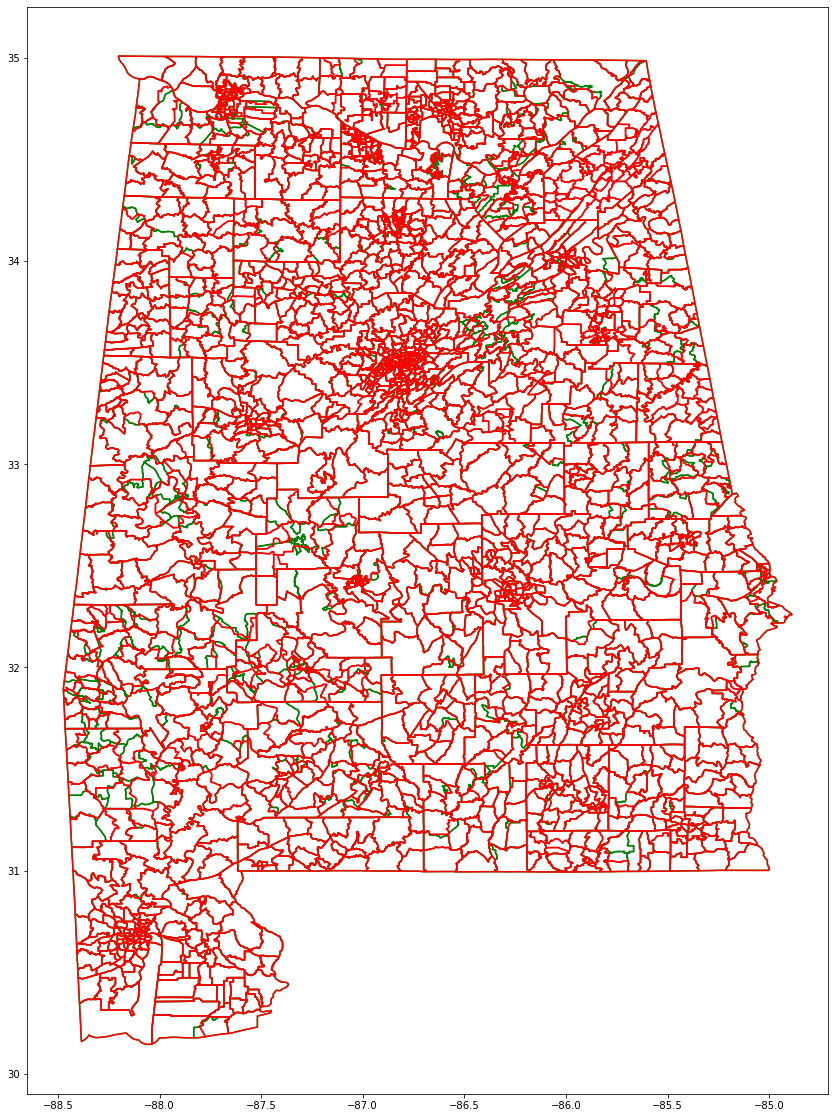

In [81]:
#Plot what they look like on top of one another, looks similar to what VEST has
ax = tiger_vtd.boundary.plot(figsize=(20,20),color="green")
vest_al_18.boundary.plot(figsize=(20,20),ax=ax,color="red")

### Shp from SOS

> Precinct shapefiles initially from the U.S. Census Bureau's 2020 Redistricting Data Program final release, except the following counties use shapefiles sourced from the respective county governments instead: Baldwin, Blount, Calhoun, Cullman, DeKalb, Franklin, Jefferson, Lee, Limestone, Madison, Marengo, Marshall, Mobile, Montgomery, Morgan, St. Clair, Shelby, Talladega, Tuscaloosa.


See the README for the list of PDF maps that are available and the few contacts we made to counties. All of these counties do not have shapefiles available for download on their website, as of 6/8/2021, except for Montgomery County. 

#### Montgomery County Shapefile

In [82]:
montgomery_shp = gp.read_file('./raw-from-source/SOS/MontgomeryCountyVotingPrecincts/MontgomeryCountyVotingPrecincts.shp')

In [83]:
montgomery_shp.head(1)

,DISTRICT,NUMERIC_RA,SHAPE_STAr,SHAPE_STLe,geometry
0,0101,101.0,7.708241e+07,49782.030847,"POLYGON ((520348.353 677246.355, 520952.903 67..."


In [84]:
montgomery_shp.shape

(49, 5)

<AxesSubplot:>

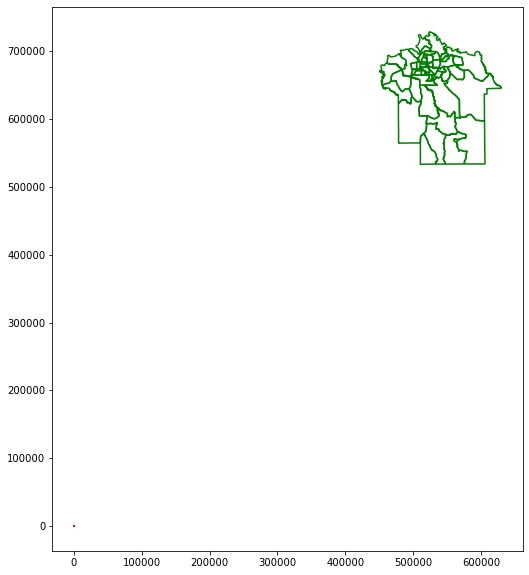

In [91]:
#Plot what they look like on top of one another, looks similar to what VEST has
ax = montgomery_shp.boundary.plot(figsize=(10,10),color="green")
vest_al_18.boundary.plot(figsize=(10,10),ax=ax,color="red")

This map does match what is on their [arcgis online](https://www.arcgis.com/home/webmap/viewer.html?webmap=dae62d97c3724628ae928db3d1e03e35&extent=-86.7154,31.985,-85.7013,32.4821) portal marked as 'Precinct Divisions', but the attribute table labels of the precincts do not match VEST's. 